# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

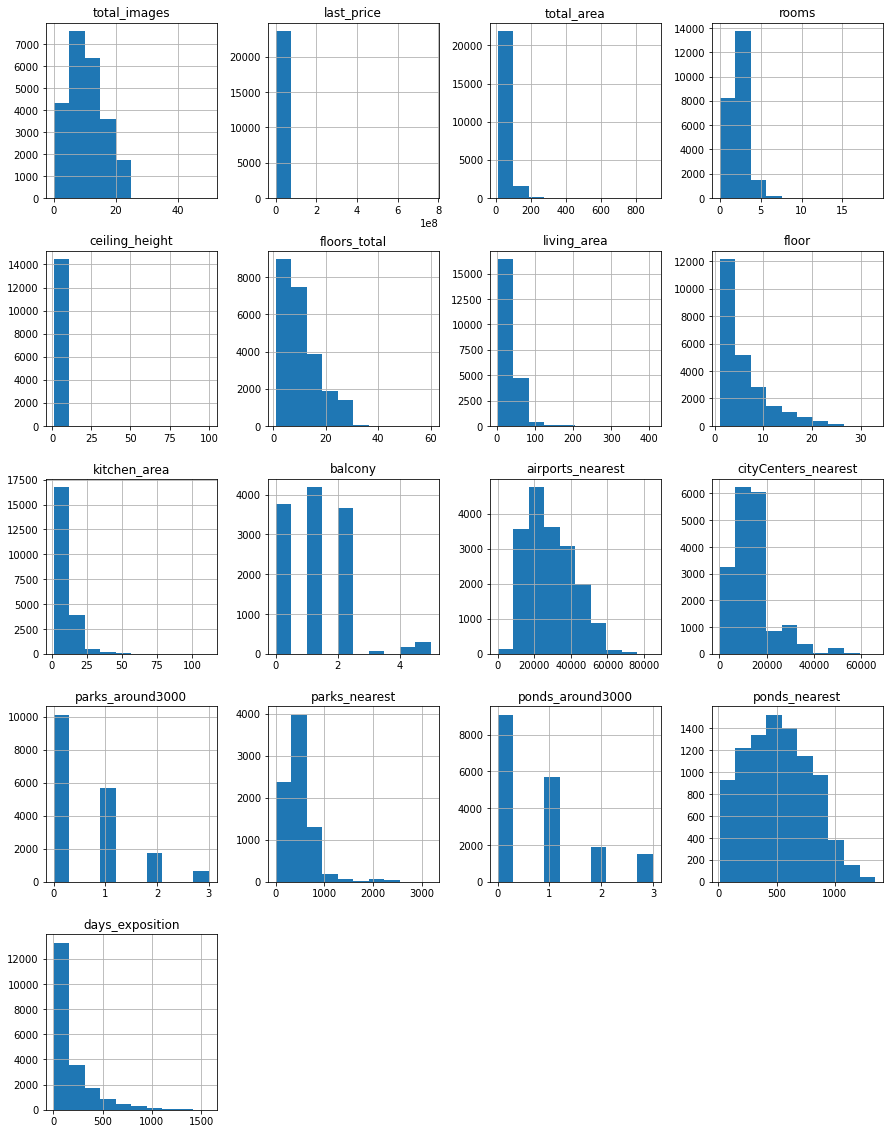

In [4]:
data.hist(figsize=(15,20)); #построим гистограмму 

Перед тем как выполнять анализ, нужно убедиться ,что данные не содержат пропуски, не имеют дубликатов, соответствую своему типу (int, float, bool). Так же  необходимо проверить странныые , аномальные значения.

### Предобработка данных

In [5]:
data.isna().sum() #найдем количество пропусков в столбцах 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Мы обнаружили пропуски в 14 столбцах: 'ceiling_height','floors_total','living_area','is_apartment','kitchen_area','balcony','locality_name','airports_nearest','cityCenters_nearest','parks_around3000','parks_nearest','ponds_around3000','ponds_nearest','days_exposition'.

Заполним пропуски ,где это возможно.

Например в столбце 'balcony' ,пропущенные значения можно заменить на 0

In [6]:
data['balcony'] = data['balcony'].fillna(0)

Так же можно предположить , что пропуски в столбцах 'parks_around3000' и 'ponds_around3000' (число парков и водоемов в радиусе 3000 м соответсвенно) равны 0

In [7]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

В столбце 'ceiling_height' пропуски можно заменить медианным значением.

In [8]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Пропуски в 'floors_total' и 'locality_name' можно удалить, так как их количество не повлияет на анлиз.

In [9]:
data = data.dropna(subset=['floors_total','locality_name'])

Предположим, что пропуски в столбце is_apartment означают, что квартира не является аппартаментами. Заполним все пропуски в данном столбце значением False:

In [10]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Пропуски в 'living_area' и 'kitchen_area' заполним значением медианной общей площади.

In [11]:
median_total_area = data['total_area'].median()
median_kitchen_area = data['kitchen_area'].median()
median_living_area = data['living_area'].median()

In [12]:
kitchen = median_kitchen_area/median_total_area
living = median_living_area/median_total_area
kitchen_median = median_total_area * kitchen
living_median = median_total_area * living

In [13]:
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen)
data['living_area'] = data['living_area'].fillna(living)

Причин появления пропусков может быть несколько. Одна из них человеческий фактор, другая это технологические ошибки , которые возникают при копировании , считывании или смене формата.

Для определения , правильности выбраного типа данных для каждого столбца , вызовем еще раз метод info()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Как видно из таблицы, в некоторых столбцах есть не соответсвие .

Для начала переименуем один столбец

In [15]:
data = data.rename(columns={'cityCenters_nearest': 'city_сenters_nearest'})

Далее в столбце 'first_day_exposition' необходимо изменить тип данных на дату, а в столбце 'is_apartment' на булевый тип. Так же в столбце 'balcony' нужно изменить на целочисленный тип данных (так как количество балконов исчесляется целым числом).

In [16]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format = '%Y-%m-%dT%H:%M:%S')

In [17]:
data['is_apartment'] = data['is_apartment'].astype('bool')

In [18]:
data['balcony'] = data['balcony'].astype('int')

In [19]:
data['locality_name'] = data['locality_name'].astype('str')

Изменять тип данных необходимо , для достовернного анализа данных.

Далее перейдем к поиску дубликатов , в столбце 'locality_name'(название населенного пункта)

Выведем все уникальные названия городов

In [20]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Создадим функцию для удаления неявных дубликатов

In [21]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
to_replace = ['поселок городского типа ', 'поселок ', 'деревня ', 'городской ', 'садовое товарищество ', 
    'садоводческое некоммерческое товарищество ', 'коттеджный ', 'поселок при железнодорожной станции']
for clean in to_replace:
  data['locality_name'] = data['locality_name'].str.replace(clean, '')

In [22]:
data['locality_name'].nunique()

310

Найдем и устраним редкие и выбивающиеся значения.

In [23]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,18041.000000,18064.000000,23565.000000,8030.000000,23565.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.724530,10.675875,31.773630,5.878124,9.581674,0.593677,28797.082701,14192.656056,0.468831,490.580448,0.589900,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,0.991026,6.594823,23.047362,4.871485,6.383323,0.960660,12632.499735,8613.348153,0.748403,341.572956,0.883966,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,0.576923,1.000000,0.175000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,17.800000,2.000000,6.300000,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,29.000000,4.000000,9.000000,0.000000,26757.000000,13096.500000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.700000,16.000000,41.100000,8.000000,11.410000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Изучим уникальные значение в столбце 'ceiling_height'

In [24]:
data['ceiling_height'].describe()

count    23565.000000
mean         2.724530
std          0.991026
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [25]:
data['ceiling_height'].unique()

array([  2.7 ,   2.65,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   3.2 ,   2.61,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,   3.3 ,
         2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,
         3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,   2.58,
         3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,   2.45,
         3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,   3.16,
         3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,   5.  ,
         2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,   2.83,
         4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,   3.18,
         3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,   2.63,
         3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,   3.66,
         3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,   3.36,
        32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,   3.26,
      

Из данных видно,что некоторые значения гораздо больше,чем другие

Допустим,что высота потолков не может быыть больше 20 , такие значения можно разделить на 2

In [26]:
data.loc[data['ceiling_height']>20, 'ceiling_height'] = data.loc[data['ceiling_height']>20, 'ceiling_height']/10
data['ceiling_height'].unique()

array([ 2.7 ,  2.65,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  3.2 ,  2.61,  3.25,  3.45,  2.77,
        2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,  2.47,
        2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,  2.51,
        2.78,  2.76,  2.58,  3.7 ,  2.52,  5.2 ,  2.87,  2.66,  2.59,
        2.  ,  2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,  3.55,
        3.16,  3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.3 ,  5.  ,
        2.79,  2.95,  4.06,  2.94,  3.82,  3.54,  3.53,  2.83,  4.7 ,
        2.4 ,  3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,  3.35,  2.3 ,
        3.57,  2.48,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,  3.95,
        3.75,  2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,  3.24,
        4.8 ,  4.5 ,  4.2 ,  3.36,  3.08,  3.68,  3.07,  3.37,  3.09,
        8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,  2.68,
        3.22,  3.27,  4.1 ,  2.93,  3.46,  3.47,  3.33,  3.63,  3.32,
        1.2 ,  8.3 ,

Высота потолков меньше 2 скорее всего тоже ошибки, их можно исключить

In [27]:
data = data.loc[data['ceiling_height']>2]
data['ceiling_height'].unique()

array([ 2.7 ,  2.65,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  3.2 ,  2.61,  3.25,  3.45,  2.77,
        2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,  2.47,
        2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,  2.51,
        2.78,  2.76,  2.58,  3.7 ,  2.52,  5.2 ,  2.87,  2.66,  2.59,
        2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,  3.55,  3.16,
        3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.3 ,  5.  ,  2.79,
        2.95,  4.06,  2.94,  3.82,  3.54,  3.53,  2.83,  4.7 ,  2.4 ,
        3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,  3.35,  2.3 ,  3.57,
        2.48,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,  3.95,  3.75,
        2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,  3.24,  4.8 ,
        4.5 ,  4.2 ,  3.36,  3.08,  3.68,  3.07,  3.37,  3.09,  8.  ,
        3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,  2.68,  3.22,
        3.27,  4.1 ,  2.93,  3.46,  3.47,  3.33,  3.63,  3.32,  8.3 ,
        2.98,  2.86,

Продолжим искать аномалии в столбце 'last_price'

In [28]:
data['last_price'].describe()

count    2.355100e+04
mean     6.541901e+06
std      1.091371e+07
min      1.219000e+04
25%      3.402500e+06
50%      4.650000e+06
75%      6.794500e+06
max      7.630000e+08
Name: last_price, dtype: float64

Можно заметить ,что минимальное значение очень маленькое. Проврим его

In [29]:
data.query('last_price == 1.219000e+04')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


Избавимся от этой строки , так как тут явная ошибка , квартира такой площади не может стоить так мало.

In [30]:
data = data[data['last_price'] != 1.219000e+04]

Проверим этот столбец на выбросы .

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

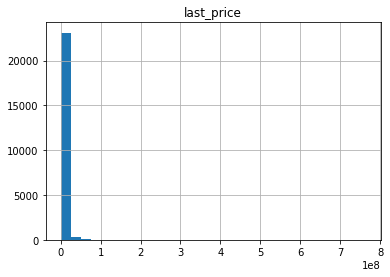

In [31]:
data.hist('last_price', bins = 30)

<AxesSubplot:>

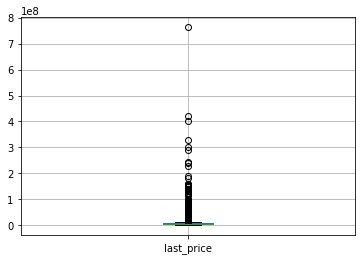

In [32]:
data.boxplot('last_price')

<AxesSubplot:>

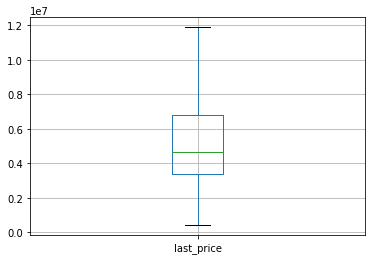

In [33]:
data.boxplot('last_price', showfliers=False)

Знаения больше 12 000 000 это выбросы

In [34]:
data = data.query('last_price < 12000000')

Затем проверим столбец 'living_area'

In [35]:
data['living_area'].describe()

count    21568.000000
mean        28.325029
std         15.320309
min          0.576923
25%         17.600000
50%         28.000000
75%         38.000000
max        160.000000
Name: living_area, dtype: float64

Проверим минимальное значение

In [36]:
data.query('living_area == 2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
13915,20,6350000.0,52.0,2018-02-06,2,3.00,6.0,2.0,2,False,False,False,9.000,0,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
21758,0,2330000.0,23.0,2018-01-01,0,2.65,24.0,2.0,22,False,True,False,0.175,0,Мурино,NaN,NaN,0.0,NaN,0.0,NaN,66.0


Такие данные не вызывают сомнения.

Проверим столбец 'rooms' на наличие аномалий

In [37]:
data['rooms'].describe()

count    21568.000000
mean         1.933652
std          0.914484
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

<AxesSubplot:>

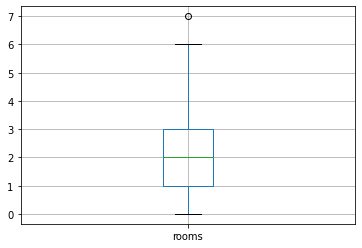

In [38]:
data.boxplot('rooms')

Значения больше 7 это выбросы 

In [39]:
data = data.query('rooms < 7')

<AxesSubplot:>

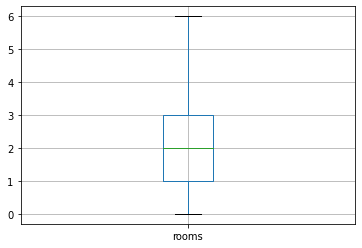

In [40]:
data.boxplot('rooms',showfliers=False )

array([[<AxesSubplot:title={'center':'rooms'}>]], dtype=object)

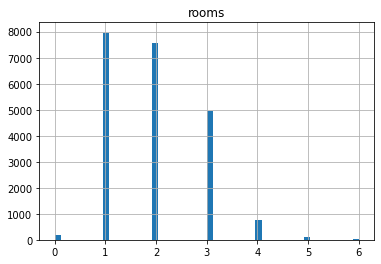

In [41]:
data.hist('rooms', range=(0,6), bins = 50)

In [42]:
data.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30,0,2.65,24.0,15.500000,2,False,True,False,0.175,2,Мурино,NaN,NaN,0.0,NaN,0.0,NaN,181.0
349,4,2320000.0,25.00,2017-09-27,0,2.65,14.0,17.000000,1,False,False,True,0.175,0,Кудрово,NaN,NaN,0.0,NaN,0.0,NaN,45.0
440,8,2480000.0,27.11,2018-03-12,0,2.65,17.0,24.750000,4,False,True,False,0.175,2,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
508,0,3375000.0,34.40,2017-03-28,0,2.65,26.0,24.300000,19,False,False,True,0.175,1,Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
608,2,1850000.0,25.00,2019-02-20,0,2.65,10.0,0.576923,7,False,True,False,0.175,0,Шушары,NaN,NaN,0.0,NaN,0.0,NaN,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01,0,2.65,25.0,18.000000,16,False,True,False,0.175,0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0
23442,0,2500000.0,27.70,2017-09-28,0,2.65,24.0,18.000000,4,False,False,True,0.175,2,Мурино,NaN,NaN,0.0,NaN,0.0,NaN,4.0
23554,15,3350000.0,26.00,2018-09-07,0,2.65,19.0,0.576923,8,False,True,False,0.175,0,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0
23592,10,1450000.0,29.00,2017-11-11,0,2.65,9.0,18.000000,8,False,False,True,0.175,2,Никольское,NaN,NaN,0.0,NaN,0.0,NaN,82.0


Каких-то аномальных значений не обнаружено. В столбце 'rooms' значение 0 означает квартира-студия.

In [43]:
data['floors_total'].describe()

count    21567.000000
mean        10.759679
std          6.635156
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

В самом высоком жилом доме Санкт-Петербурга максмальный этаж 37, значение 60 является аномалией. Удалим строку с этим значением.

In [44]:
data.query('floors_total == 60')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60.0,27.4,4,False,False,False,7.4,0,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0


In [45]:
data = data[data['floors_total'] != 60]

Проверим столбец 'airports_nearest' на наличе аномалий.

In [46]:
data['airports_nearest'].describe()

count    16090.000000
mean     28904.301865
std      12984.249076
min          0.000000
25%      18079.000000
50%      27006.000000
75%      37625.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Проверм максимальное значение 84 км.

In [47]:
data.query('airports_nearest == 84869')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9640,8,4200000.0,51.4,2014-12-10,2,2.55,5.0,31.0,2,False,False,False,6.0,1,Молодежное,84869.0,65968.0,0.0,NaN,0.0,NaN,1194.0


Обратившись к картам , можно обнаружить,, что эти данные правильныые. 

Проверим столбец 'city_сenters_nearest' на наличие аномалий.

In [48]:
data['city_сenters_nearest'].describe()

count    16102.000000
mean     14954.930506
std       8563.914453
min        208.000000
25%      10584.000000
50%      13608.000000
75%      16688.250000
max      65968.000000
Name: city_сenters_nearest, dtype: float64

Никаких выделяющихся значений не обнаружено.

Проверим столбец 'parks_around3000' на наличие аномалий.

In [49]:
data['parks_around3000'].describe()

count    21566.000000
mean         0.417463
std          0.705008
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

Так же мы видим, что никаких выделяющихся значений нет.

Проверим столбец 'parks_nearest' на наличие аномалий 

In [50]:
data['parks_nearest'].describe()

count    6719.000000
mean      488.979312
std       329.281718
min         1.000000
25%       289.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

В этом столбце также все в порядке.

Проверим столбец 'ponds_around3000' на наличие аномалий 

In [51]:
data['ponds_around3000'].describe()

count    21566.000000
mean         0.530557
std          0.831095
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

В общем и целом здесь тоже все в порядке.

Проверим столбец 'ponds_nearest'.

In [52]:
data['ponds_nearest'].describe()

count    7741.000000
mean      531.315851
std       277.516883
min        16.000000
25%       315.000000
50%       521.000000
75%       741.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

Никаких аномалий не обнаружено.

Проверим столбец 'days_exposition'.

In [53]:
data['days_exposition'].describe()

count    18932.000000
mean       173.404236
std        212.005762
min          1.000000
25%         44.000000
50%         91.000000
75%        219.000000
max       1580.000000
Name: days_exposition, dtype: float64

Тут тоже все в порядке.

In [54]:
data['total_area'].describe()

count    21566.000000
mean        53.381154
std         19.217563
min         12.000000
25%         39.000000
50%         49.400000
75%         63.800000
max        230.000000
Name: total_area, dtype: float64

Проверим этот столбец на выбросы

(0.0, 150.0)

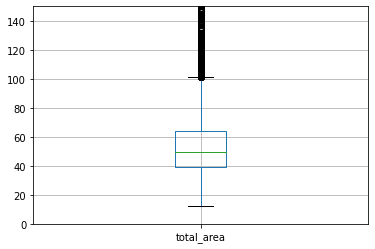

In [55]:
data.boxplot('total_area')
plt.ylim(0,150)

Значения больше 110 это выбросы


<AxesSubplot:>

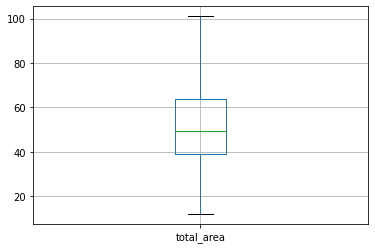

In [56]:
data.boxplot('total_area', showfliers=False)

In [57]:
data = data.query('total_area < 110')

Избавились от выбросов в столбце 'total_area' 

### Посчитайте и добавьте в таблицу новые столбцы

Добавим в таблицу новый столбец 'price_per_meter'. Разделим цену квартиры 'last_price' на общую площдь квартиры 'total_area'.

In [58]:
data['price_per_meter'] = data['last_price']/data['total_area']

Добавим в таблицу столбец день недели публикации 'week_day', стобец с месяцем публикации 'month_exposition' и с годом публикации 'year_exposition'.

In [59]:
data['week_day'] = data['first_day_exposition'].dt.dayofweek
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

Добвавим столбец , где указан тип этажа квартиры.

In [60]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

data['floor_type'] = data.apply(floor_type, axis=1)

In [61]:
data[['floor', 'floor_type']]

,floor,floor_type
1,1,первый
2,4,другой
4,13,другой
5,5,другой
6,6,другой
...,...,...
23693,8,другой
23695,4,другой
23696,1,первый
23697,12,другой


Далее добавим столбец с информацией о расстоянии в км до центра города

In [62]:
data['city_сenters_nearest_km'] = round(data['city_сenters_nearest']/1000)

In [63]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,week_day,month_exposition,year_exposition,floor_type,city_сenters_nearest_km
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.600000,1,False,False,False,11.000,2,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.300000,4,False,False,False,8.300,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.000000,13,False,False,False,41.000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.400000,5,False,False,False,9.100,0,Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0,95065.789474,0,9,2018,другой,NaN
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.600000,6,False,False,False,14.400,1,Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23693,9,4600000.0,62.40,2016-08-05,3,2.60,9.0,40.000000,8,False,False,False,8.000,0,Петергоф,45602.0,34104.0,1.0,352.0,1.0,675.0,239.0,73717.948718,4,8,2016,другой,34.0
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5.0,38.000000,4,False,False,False,8.500,0,Тосно,NaN,NaN,0.0,NaN,0.0,NaN,45.0,52542.372881,0,1,2018,другой,NaN
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3.0,29.700000,1,False,False,False,0.175,0,село Рождествено,NaN,NaN,0.0,NaN,0.0,NaN,NaN,44091.710758,6,2,2018,первый,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,0.576923,12,False,False,False,23.300,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,149511.400651,1,3,2017,другой,10.0


### Проведите исследовательский анализ данных

Построим гистограммы для некотоых параметров из таблицы , а именно:
- общая площадь
*жилая площадь
*площадь кухни
*цена объекта
*количество комнат
*высота потолков
*этаж квартиры
*тип этажа квартиры («первый», «последний», «другой»)
*общее количество этажей в доме
*расстояние до центра города в метрах
*расстояние до ближайшего аэропорта
*расстояние до ближайшего парка
*день и месяц публикации объявления

<AxesSubplot:>

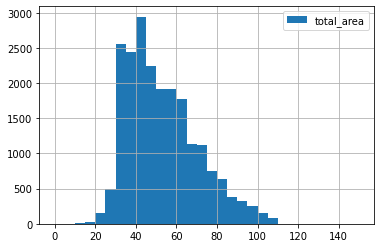

In [64]:
data['total_area'].hist(legend=True,range=(0,150),bins=30)

В основном квартиры продатся с общей площадью от 20 до 100 кв.м 

<AxesSubplot:>

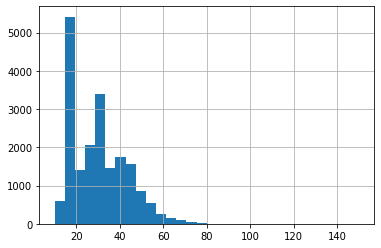

In [65]:
data['living_area'].hist(range = (10,150),bins=30)

Обычно жилая площадь составляет от 15 до 50 кв.м

<AxesSubplot:>

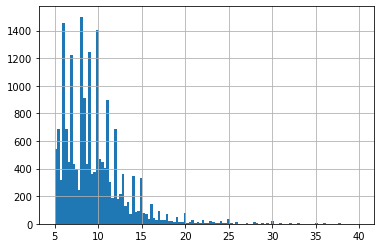

In [66]:
data['kitchen_area'].hist(range = (5,40),bins='auto')

Кухонная площадь обыычно имеет значение от 5 до 15 кв.м

<AxesSubplot:>

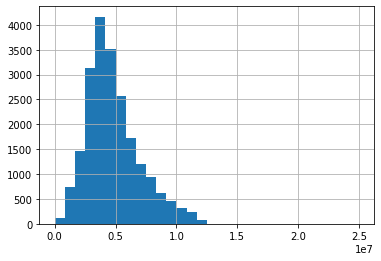

In [67]:
data['last_price'].hist(range = (0,0.25e8),bins=30)

Большинство квартир продаются по цене до 10 млн. Самое большое количество квартир до 5 млн.


<AxesSubplot:>

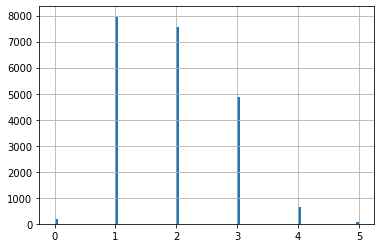

In [68]:
data['rooms'].hist(range = (0,5),bins=100)

Большинство квартир на рынке недвижимости одно-, двух- и трех- комнатные.

<AxesSubplot:>

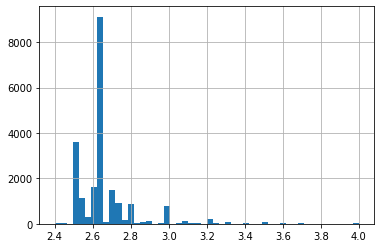

In [69]:
data['ceiling_height'].hist(range=(2.4,4),bins=50)

Бльше всего квартир с высотой потолков 2,5-2,7 метра

<AxesSubplot:>

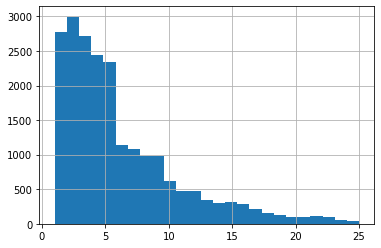

In [70]:
data['floor'].hist(range=(1,25),bins=25)

В основном квартиры размещаются до 10 этажа.

<AxesSubplot:>

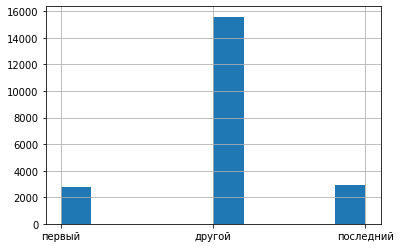

In [71]:
data['floor_type'].hist()

На рынке недвижимости больше всего квартир не на первом и не на поседнем этаже.

<AxesSubplot:>

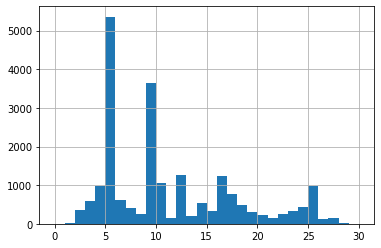

In [72]:
data['floors_total'].hist(range=(0,30),bins=30)

Данная гистограмма подтверждает ,что большинство квартир продаются в 5ти этажной застройке.Так же много квартир представлены в 9ти этажной застройке.

<AxesSubplot:>

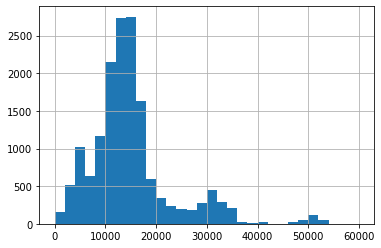

In [73]:
data['city_сenters_nearest'].hist(range=(0,60000), bins = 30)

В основном квартиры располагаются до 15 км от центра города.

Проверим всплески от 30 до 55 км от города.

In [74]:
data[(data['city_сenters_nearest'] > 30000 ) & (data['city_сenters_nearest'] < 55000)]['locality_name'].value_counts()

Колпино         313
Петергоф        190
Сестрорецк      163
Пушкин          135
Ломоносов       126
Шушары           95
Кронштадт        91
Красное Село     66
Павловск         36
Понтонный        20
Зеленогорск      16
Саперный          6
Репино            2
Белоостров        1
Name: locality_name, dtype: int64

Всплески обусловлены наличием больших населенных пунктов в пригороде Санкт-Петербурга.

<AxesSubplot:>

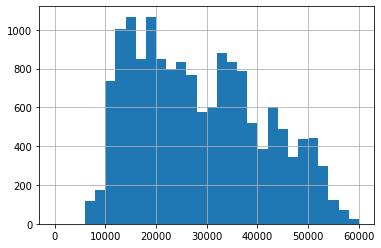

In [75]:
data['airports_nearest'].hist(bins=30,range=(0,60000))

Так как аэропорт находистя за городом, почти все квартиры находятся на расстоянии от 10 км от аэропорта.

<AxesSubplot:>

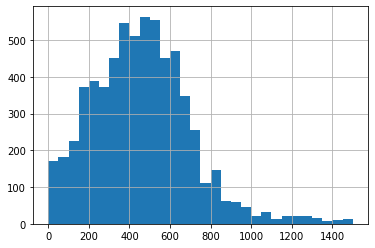

In [76]:
data['parks_nearest'].hist(range=(0,1500),bins=30)

Наличие рядом с кватирой парка,является преимуществом. В основном квартиры расположены до 800 метров от парка.

<AxesSubplot:>

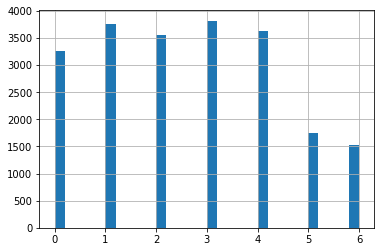

In [77]:
data['week_day'].hist(bins=30)

Большенство объявлений публикуют в будние дни. На выходных заметен спад публикации.

<AxesSubplot:>

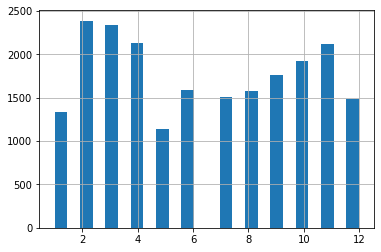

In [78]:
data['month_exposition'].hist(bins=24)

На гистограмме заметно, что сезоном продажи квартиры являются февраль,март,апрель,сентябрь,октябрь и ноябрь.

Изучим как быстро продовались квартиры

<AxesSubplot:>

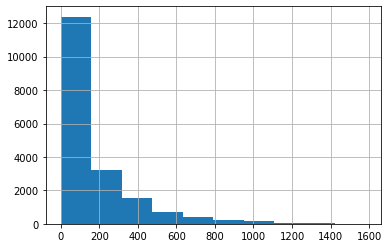

In [79]:
data['days_exposition'].hist()

Сделаем числовое описание 'days_exposition' и построим диаграмму размаха

In [80]:
data['days_exposition'].describe()

count    18698.000000
mean       171.726120
std        209.980971
min          1.000000
25%         43.000000
50%         91.000000
75%        217.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

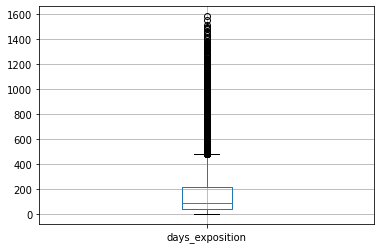

In [81]:
data.boxplot('days_exposition')

(0.0, 550.0)

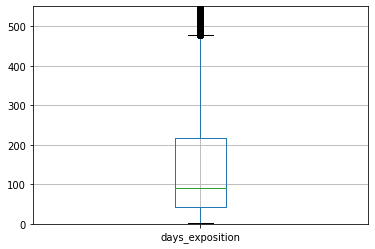

In [82]:
data.boxplot('days_exposition')
plt.ylim(0, 550)

Минимальное количество дней объявления на сайте - 1 день. Среднее количество дней - 180. Медианное значение - 95. Максимальное - 1580 дней.

Квартиры которые продавались , больше 500 дней это выбросы

Следовательно обычно квартиры продаются за 95 дней. 25% квартир продаются от 0 до 45 дней. Это является быстрой продажей . 75% квартир продаются до 231 день. И медленные продажи квартир от 231 до 500 дней.

Изучим какие из этих факторов влияют на общую стоимость объекта.
- общей площади;
- жилой площади;
- площади кухни;
- количество комнат;
- типа этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год);

Зависит ли цена от общей площади.

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

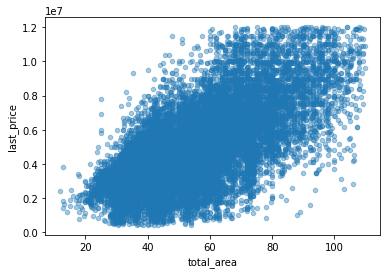

In [83]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.4)

In [84]:
data['total_area'].corr(data['last_price'])

0.6931894530199184

Мы посчитали корреляцию и увидели явную зависимость между ценой квартиры и общей площадью.Чем больше площадь, тем выше цена.

Зависит ли цена от жтлой площади.

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

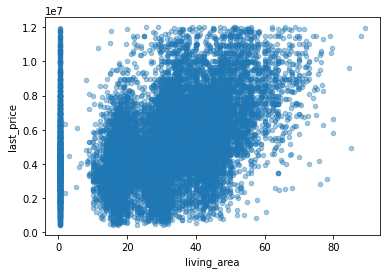

In [85]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.4)

In [86]:
data['living_area'].corr(data['last_price'])

0.46729746064512717

Мы посчитали корреляцию и увидели зависимость цены квартиры от жтлой площади. Чем больше жилая площадь, тем выше цена квартиры.

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

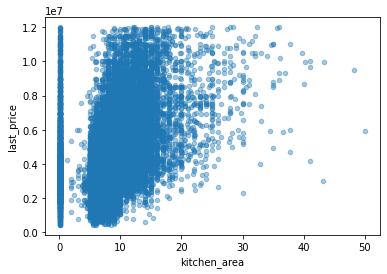

In [87]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.4)

In [88]:
data['kitchen_area'].corr(data['last_price'])

0.40911560622447174

Корреляция горазд меньше ,чем в предыдущих пунктах. Поэтому можно сделать вывод: площадь кухни тоже влияет на цену квартиры, но зависимость не такая сильная. 

Изучим зависит ли цена от количества комнат.

<AxesSubplot:xlabel='rooms', ylabel='last_price'>

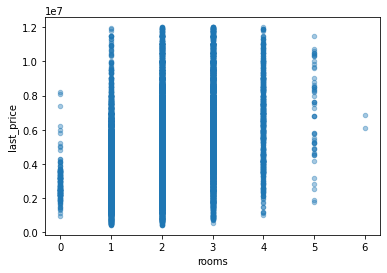

In [89]:
data.plot(x='rooms', y='last_price', kind='scatter', alpha=0.4)

In [90]:
data['rooms'].corr(data['last_price'])

0.42469664361533044

На графике видно ,что корреляция проявляется сильнее в квартирах до 5ти комнат. Так же заметим,что ,чем больше комнат , тем больше ена квартиры,но зависимость небольшая.

Изучим зависит ли цена от типа этажа. на котором расположена квартира.

In [91]:
data.pivot_table(index='floor_type', values='last_price', aggfunc='median').sort_values(by='last_price')

,last_price
floor_type,
первый,3800000.0
последний,4000000.0
другой,4550000.0


<AxesSubplot:xlabel='floor_type', ylabel='last_price'>

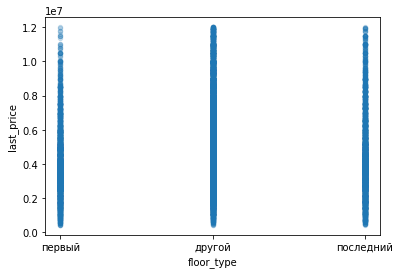

In [92]:
data.plot(x='floor_type', y='last_price', kind='scatter', alpha=0.2)


Цена квартиры на последнем этаже самая большая. Дешевле на других этажах и самые дешевые квартиры на первом этаже.

Изучим ,зависит ли цена от дня рамещения объявления.

In [93]:
day_price = data.pivot_table(index='week_day', values='last_price', aggfunc='median').reset_index()

<AxesSubplot:xlabel='week_day'>

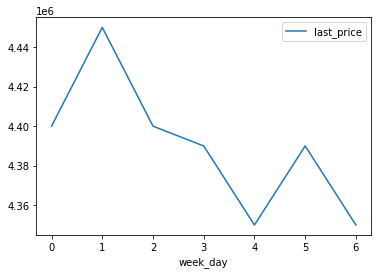

In [94]:
day_price.plot(x='week_day', y='last_price')

Из графика можно сделать вывод, что в пятницу,субботу и воскресень цена вставленных квартир, еньше ,чем в начале и середине недели.

Изучим ,зависит ли цена от месяца рамещения объявления.

In [95]:
month_price = data.pivot_table(index='month_exposition', values='last_price', aggfunc='median').reset_index()
month_price

,month_exposition,last_price
0,1,4380000.0
1,2,4390000.0
2,3,4400000.0
3,4,4550000.0
4,5,4300000.0
5,6,4200000.0
6,7,4340000.0
7,8,4350000.0
8,9,4400000.0
9,10,4377500.0


(4000000.0, 5500000.0)

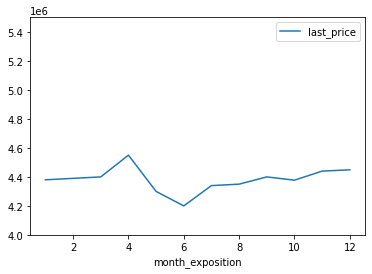

In [96]:
month_price.plot(x='month_exposition', y='last_price')
plt.ylim(4000000,5500000)

По графику можно увидеть, что какой-либо зависимости в цене квартиры от месяца года нет.

In [97]:
year_price = data.pivot_table(index='year_exposition', values='last_price', aggfunc='median').reset_index()
year_price

,year_exposition,last_price
0,2014,5425000.0
1,2015,4790000.0
2,2016,4270000.0
3,2017,4250000.0
4,2018,4350000.0
5,2019,4800000.0


<AxesSubplot:xlabel='year_exposition'>

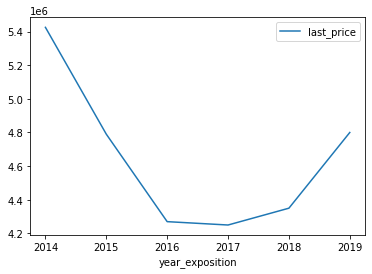

In [98]:
year_price.plot(x='year_exposition', y='last_price')

Цена квартир с 2014 года по 2017 резко уменьшалось, с 2018 заметен небольшоя рост.

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

Найдем 10 населенных пунктов с наибльшим числом объявлений.Для начала создадим сводную таблицу.

In [99]:
data_price = data.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['count', 'mean']).reset_index() 
data_price

,locality_name,count,mean
,,price_per_meter,price_per_meter
0,Агалатово,4,71214.470963
1,Александровская,1,63559.322034
2,Алексеевка,1,22222.222222
3,Аннино,16,63322.637137
4,Аро,3,51412.421933
...,...,...,...
304,станции Громово,3,34081.684424
305,станции Корнево,1,82568.807339
306,станции Лужайка,1,15000.000000


Переименуем столбцы

In [100]:
data_price.columns = ('locality_name','count','mean')
data_price

,locality_name,count,mean
0,Агалатово,4,71214.470963
1,Александровская,1,63559.322034
2,Алексеевка,1,22222.222222
3,Аннино,16,63322.637137
4,Аро,3,51412.421933
...,...,...,...
304,станции Громово,3,34081.684424
305,станции Корнево,1,82568.807339
306,станции Лужайка,1,15000.000000
307,станции Приветнинское,2,57079.365079


Отсортируем по убыванию и выделим первые 10 строк.

In [101]:
data_price_sort = data_price.sort_values(by='count',ascending = False)
data_price_10 = data_price_sort.head(10)

Отсортируем по средней цене за квадратный метр.

In [102]:
data_price_10 = data_price_10.sort_values(by='mean',ascending = False)
data_price_10

,locality_name,count,mean
213,Санкт-Петербург,13523,105901.862723
194,Пушкин,337,100493.971120
102,Кудрово,467,95087.724999
165,Парголово,325,90417.201454
141,Мурино,586,86041.116064
283,Шушары,432,78620.137735
87,Колпино,335,75221.876295
41,Гатчина,303,68664.035870
33,Всеволожск,393,67284.294016
34,Выборг,225,58293.652302


Сделаем новую индексацию и оставим только 2 сотлбика 'locality_name' и 'mean'.

In [103]:
data_price_10 = data_price_10.reset_index().loc[:, ['locality_name','mean']]
data_price_10

,locality_name,mean
0,Санкт-Петербург,105901.862723
1,Пушкин,100493.971120
2,Кудрово,95087.724999
3,Парголово,90417.201454
4,Мурино,86041.116064
5,Шушары,78620.137735
6,Колпино,75221.876295
7,Гатчина,68664.035870
8,Всеволожск,67284.294016
9,Выборг,58293.652302


Из таблицы можно сделать выво, что самый дорогой квадратный метр квартиры в г.Санкт-Петербург , самый дешевый в г.Выборг.

Далее выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим среднюю цену каждого километра.

In [104]:
data_Spb_centers = data.query('locality_name == "Санкт-Петербург"').pivot_table(index='city_сenters_nearest_km',values='last_price', aggfunc='mean').reset_index()
data_Spb_centers

,city_сenters_nearest_km,last_price
0,0.0,8.053333e+06
1,1.0,8.128573e+06
2,2.0,7.792000e+06
3,3.0,7.190386e+06
4,4.0,7.426364e+06
5,5.0,7.543457e+06
6,6.0,7.059173e+06
7,7.0,6.690837e+06
8,8.0,6.582529e+06
9,9.0,5.535010e+06


Построим график

<AxesSubplot:xlabel='city_сenters_nearest_km'>

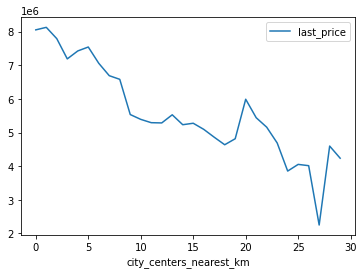

In [105]:
data_Spb_centers.plot(x='city_сenters_nearest_km', y='last_price')

Посчитаем корреляцию.

In [106]:
data_Spb_centers['city_сenters_nearest_km'].corr(data['last_price'])

0.14323133732518764

Отрицательная корреляция означает,что при удалении от центра цена квартиры будет уменьшаться. На график видны всплески, это может означать наличи элитных райоов в удалении от центра.

### Общий вывод

Мы проанализировлаи данные сервиса Яндекс.Недвижимость. Для начала произвели предобработку данных , избавились от дубликатов , заменили,где можо, пропущенные значения. Выяснили , что на рынке недвижимости в основном продаются квартиры с общей площадью от 30 до 100 кв.м. Обычно жилая площадь составляет от 15 до 50 кв.м . Кухонная площадь обычно имеет значение от 5 до 15 кв.м. Большинство квартир продаются по цене до 10 млн. Самое большое количество квартир до 5 млн. Так же выяснили,что большинство квартир на рынке недвижимости одно-, двух- и трех- комнатные. Изучили высоту потолков больше всего квартир с высотой потолков 2,5-2,7 метра. В основном квартиры размещаются до 10 этажа. На рынке недвижимости больше всего квартир не на первом и не на поседнем этаже. Узнали,что большая часть квартир продаются в 5ти этажной застройке.Так же много квартир представлены в 9ти этажной застройке. В основном квартиры располагаются до 15 км от центра города. Из-за отдаленност аэопорта ,почти все квартиры находятся на расстоянии от 10 км от аэропорта.Наличие рядом с кватирой парка,является преимуществом. В основном квартиры расположены до 800 метров от парка.Большенство объявлений публикуют в будние дни. Сезоном продажи квартиры являются февраль,март,апрель,сентябрь,октябрь и ноябрь. В основном квартиры продются за 95 дней. 


Цена квартиры напрямую зависит от общей площади,кухоннй площади и жилой площади. Чем больше комнат , тем больше цена квартиры,но зависимость небольшая. Цена квартиры на последнем этаже самая большая. Дешевле на других этажах и самые дешевые квартиры на первом этаже. В пятницу,субботу и воскресень цена вставленных квартир, меньше ,чем в начале и середине недели. Какой-либо зависимости в цене квартиры от месяца года нет. Цена квартир с 2014 года по 2017 резко уменьшалось, с 2018 заметен небольшоя рост. Самый дорогой квадратный метр квартиры в г.Санкт-Петербург (в среднем 114877 руб) , самый дешевый в г.Выборг (в среднем 58238). При удалении от центра цена квартиры будет уменьшаться. На график видны всплески, это может означать наличи элитных райоов в удалении от центра.